In [3]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

(0.00159953, 3340.0)

In [28]:
from ombre.query import get_nexsci
from ombre import Spectrum, Spectra
from astropy.io import fits
from astropy.constants import sigma_sb
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
plt.style.use('seaborn-white')
from glob import glob
import numpy as np
import lightkurve as lk
from tqdm import tqdm

In [29]:
fnames = np.sort(np.asarray(glob('results/*_stellar_spectrum.fits')))
f = fnames[np.where(np.asarray([Spectra.from_file(fname)[0].meta['st_teff'] for fname in fnames]) < 4500)]
teff = np.asarray([Spectra.from_file(fname)[0].meta['st_teff'] for fname in f])
s = np.argsort(teff)

y, W, T = [], [], []
label = 'G141'
pnames = []
for idx, fname in enumerate(f[s]):
    hdu = fits.open(fname)
    name = '_'.join(fname.split('/')[1].split('_')[:-2])
    sp = Spectra.from_file(fname)
    k = np.where([v == label for v in sp.visits])[0]
    if len(k) == 0:
        continue
    
    sp = sp[k].flatten()
    print(fname, sp.meta['st_teff'])
    pnames.append(fname.split('/')[-1].split('_')[0])
    corr = np.median(sp.spec[(sp.wavelength.value > 1.275*1e4) & (sp.wavelength.value < 1.325*1e4)])
    y.append(sp.spec/corr)
    W.append(sp.wavelength)
    T.append(np.ones_like(sp.wavelength.value) * sp.meta['st_teff'])
y, W, T = np.hstack(y), np.hstack(W), np.hstack(T)
s = np.argsort(W)
y, W, T = y[s], W[s], T[s]

results/TRAPPIST_stellar_spectrum.fits 2566.0
results/GJ-3053_stellar_spectrum.fits 3216.0
results/LHS_1140_stellar_spectrum.fits 3216.0
results/GJ1214_stellar_spectrum.fits 3250.0
results/LHS_281_stellar_spectrum.fits 3270.0
results/L98-59_stellar_spectrum.fits 3415.0
results/K2-18_stellar_spectrum.fits 3457.0
results/GJ436_stellar_spectrum.fits 3586.11
results/GJ3470_stellar_spectrum.fits 3600.0
results/KEPLER-138_stellar_spectrum.fits 3841.0
results/K2-3_stellar_spectrum.fits 3896.0
results/WASP-80_stellar_spectrum.fits 4143.0
results/GJ9827b_stellar_spectrum.fits 4340.0
results/GJ9827d_stellar_spectrum.fits 4340.0
results/WASP-43_stellar_spectrum.fits 4400.0
results/WASP-107_stellar_spectrum.fits 4425.0


Text(0.5, 1.0, 'Data')

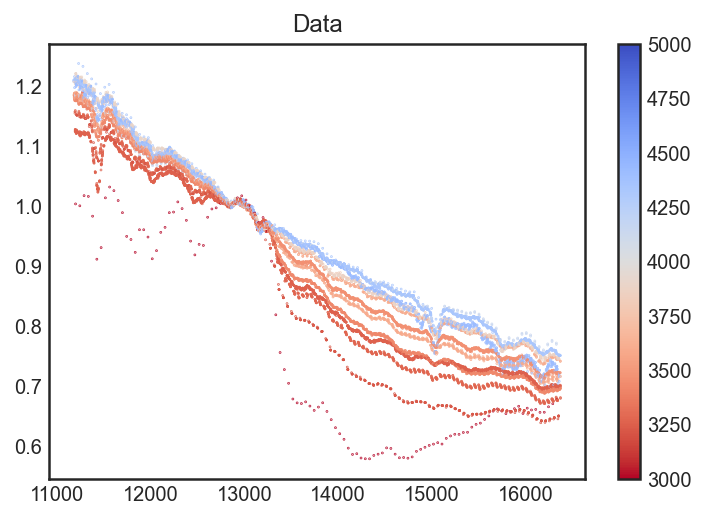

In [30]:
plt.scatter(W, y, s=0.1, c=T, cmap='coolwarm_r', vmin=3000, vmax=5000)
plt.colorbar()
plt.title('Data')

In [31]:
# wknots = np.linspace(1.1, 1.7, 150) * 1e4
# tknots = list(np.linspace(teff.min(), teff.max(), 8))[1:-1]

In [32]:
# plt.plot(np.sort(teff), marker='.')
# plt.plot(tknots)

In [33]:
# X1 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), W, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
# X_teff = lk.designmatrix.create_spline_matrix(T, knots=tknots, degree=2).X
# A = np.hstack([X1[:, idx][:, None] * X_teff for idx in range(X1.shape[1])])
# k = np.isfinite(y)
# sigma_w_inv = A[k].T.dot(A[k]) + np.diag(1/(np.ones(A.shape[1]) * 10000))
# w = np.linalg.solve(sigma_w_inv, A[k].T.dot(y[k]))
# model = A.dot(w)

In [34]:
# plt.scatter(W, model, s=0.1, c=T, cmap='coolwarm')
# plt.colorbar()

In [35]:
# name = 'K2-18'
# sp = Spectra.from_file(f'results/{name}_transmission.fits').flatten()
# sp = sp[np.argsort(sp.wavelength)]
# phot_temp = sp.meta['st_teff']
# spot_temps = np.linspace(phot_temp - 250, phot_temp)[::-1]
# chi1 = np.sum(((sp.spec)**2/sp.spec_err**2))/len(sp.wavelength - 1)
# X2 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), sp.wavelength*1e4, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
# X_teff = lk.designmatrix.create_spline_matrix(np.hstack([0, (spot_temps[:, None] * np.ones_like(sp.wavelength)).ravel(), 10000]), knots=tknots, degree=2).X[1:-1]
# X_teff = X_teff.reshape((spot_temps.shape[0], sp.wavelength.shape[0], X_teff.shape[-1]))


# spot_area = 0.1
# planet_area = sp.meta['radius']**2/sp.meta['st_rad']**2
# A = np.hstack([X2[:, idx][:, None] * X_teff[0] for idx in range(X2.shape[1])])
# phot_model = A.dot(w)
# for jdx, spot_temp in enumerate(spot_temps):
#     A = np.hstack([X2[:, idx][:, None] * X_teff[jdx] for idx in range(X2.shape[1])])
#     spot_model = A.dot(w)
#     spot_model *= spot_temp**4/phot_temp**4
    
#     oot = (phot_model * (1 - spot_area) + spot_model * spot_area)
#     it = (phot_model * (1 - spot_area - planet_area) + spot_model * spot_area)
#     if jdx == 30:
#         break


In [36]:
wknots = np.linspace(1.1, 1.7, 150) * 1e4
X1 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), W.value, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
A = np.hstack([X1, X1*T[:, None], X1*T[:, None]**2, X1*T[:, None]**3])
k = np.isfinite(y)
sigma_w_inv = A[k].T.dot(A[k]) + np.diag(1/(np.ones(A.shape[1]) * 10000))
w = np.linalg.solve(sigma_w_inv, A[k].T.dot(y[k]))
model = A.dot(w)

(0.5459568348124887, 1.2697993278474486)

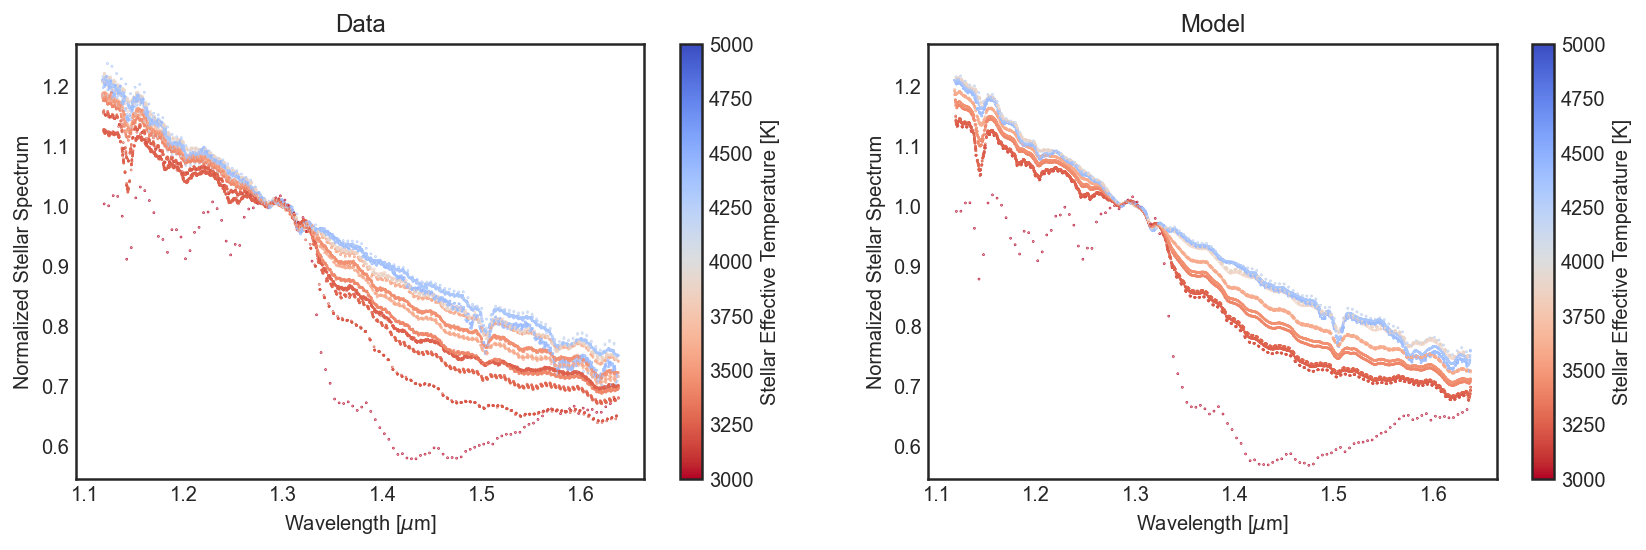

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
im = ax[0].scatter(W*1e-4, y, s=0.1, c=T, cmap='coolwarm_r', vmin=3000, vmax=5000)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Stellar Effective Temperature [K]')
ax[0].set(title=('Data'), ylabel='Normalized Stellar Spectrum', xlabel='Wavelength [$\mu$m]')

im = ax[1].scatter(W*1e-4, model, s=0.1, c=T, cmap='coolwarm_r', vmin=3000, vmax=5000)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Stellar Effective Temperature [K]')
ax[1].set(title=('Model'), ylabel='Normalized Stellar Spectrum', xlabel='Wavelength [$\mu$m]')
ax[1].set_ylim(ax[0].get_ylim())

/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_13706/3403792279.py:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.linspace(3000, 5000, 51), np.logspace(-4, -1.5, 50), Hs, vmin=0, vmax=50)


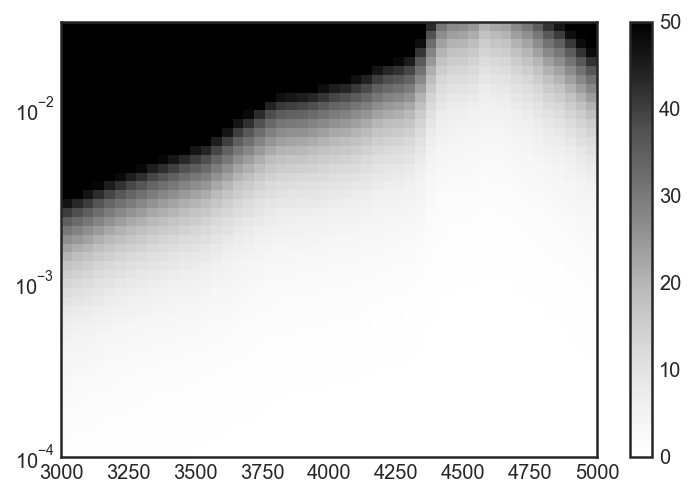

In [89]:
wavelength = np.linspace(1.12, 1.6, 300)
chi1 = np.sum(((sp.spec)**2/sp.spec_err**2))/len(wavelength - 1)
X2 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), wavelength * 1e4, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
dspot_temps = np.linspace(0, 400, 50)
spot_areas = np.linspace(0.01, 0.6, 51)

ts_models = np.zeros((51, 50, wavelength.shape[0]))

apart = (wavelength >= 1.335) & (wavelength < 1.55)
bpart = (wavelength >= 1.15) & (wavelength < 1.335)

plt.figure()
planet_area = 0.001
star_temp = 3000
spot_area = 0.15
Hs = np.zeros((50, 51))
dspot_temps = np.atleast_1d(200)

for idx, planet_area in enumerate(np.logspace(-4, -1, 50)):
    for jdx, star_temp in enumerate(np.linspace(2500, 5000, 51)):
        phot_temps = dspot_temps * spot_area + star_temp
        spot_temps = phot_temps - dspot_temps
        spot_model = np.vstack([np.hstack([X2, X2 * spot_temp, X2 * spot_temp**2, X2 * spot_temp**3]).dot(w) for spot_temp in spot_temps]).T

        #    phot_temps = (sp.meta['st_teff'] - (spot_area * spot_temps))/(1 - spot_area)
        phot_model = np.vstack([np.hstack([X2, X2 * phot_temp, X2 * phot_temp**2, X2 * phot_temp**3]).dot(w) for phot_temp in phot_temps]).T
        ###spot_model *= spot_temps**4/phot_temp**4

        #oot = (phot_model[:, None] * (1 - spot_area) + spot_model * spot_area)
        #it = (phot_model[:, None] * (1 - spot_area - planet_area) + spot_model * spot_area)
        oot = (phot_model * (1 - spot_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
        it = (phot_model * (1 - spot_area - planet_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
        ts_model = ((oot - it)/oot - planet_area)
        ts_model -= np.nanmedian(ts_model, axis=0)
        Hs[idx, jdx] = (1e6*np.percentile(ts_model.ravel()[apart], 80) - np.percentile(ts_model.ravel()[bpart], 20)).value

plt.pcolormesh(np.linspace(3000, 5000, 51), np.logspace(-4, -1.5, 50), Hs, vmin=0, vmax=50)
plt.colorbar()
plt.yscale('log')

In [53]:
jwstplanets = ['55 Cnc e', '55 Cnc e', '55 Cnc e', '55 Cnc e', 'GJ486 b / WOLF 437 b', 'GJ486 b / WOLF 437 b', 'HD 189733 b', 'HD 189733 b', 'LHS 3844 b', 'LHS 3844 b', 'LTT 1445A b', 'LTT 1445A b', 'LTT 1445A b', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'GJ 1214 b', 'TOI 731.01', 'HD 80606 b', 'HD 80606 b', 'K2-141 b', 'K2-141 b', 'NGTS-10 b', 'WASP-121 b', 'GJ 1132 b', 'GJ 1132 b', 'GJ 341 b/TOI 741.01', 'GJ 341 b/TOI 741.01', 'GJ 341 b/TOI 741.01', 'GJ 357 b/TOI 562.01', 'GJ 4102 b/TOI 910.01', 'GJ 4102 b/TOI 910.01', 'GJ 4102 b/TOI 910.01', 'GJ486 b / WOLF 437 b', 'GJ486 b / WOLF 437 b', 'HATS-72 b', 'HATS-72 b', 'HD 189733b', 'HD 189733b', 'HD 189733b', 'HD 189733b', 'HD 209458 b', 'HIP 67522 b', 'K2-18 b', 'K2-18 b', 'K2-18 b', 'K2-18 b', 'K2-18 b', 'K2-18 b', 'K2-18 b', 'K2-18 b', 'K2-18 b', 'Kepler-51 b', 'Kepler-51 d', 'L 98-59 c/TOI 175.01', 'L 98-59 c/TOI 175.01', 'LHS 1140 b', 'LHS 1140 b', 'LTT 1445A b/TOI 455.01', 'TOI 134.01', 'TOI 134.01', 'TOI 134.01', 'TOI 178 b', 'TOI 178 d', 'TOI 178 g', 'TOI 260.01', 'TOI 260.01', 'TOI 402.01', 'TOI 402.01', 'TOI 402.02', 'TOI 776.01', 'TOI 776.01', 'TOI 776.02', 'TOI 776.02', 'TOI 836.01', 'TOI 836.02', 'TOI 836.02', 'TOI-421 b', 'TOI-421 b', 'TRAPPIST-1 b', 'TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'TRAPPIST-1 c', 'TRAPPIST-1 g', 'TRAPPIST-1 g', 'TRAPPIST-1 h', 'TRAPPIST-1 h', 'TRAPPIST-1 h', 'V1298 Tau b', 'V1298 Tau b', 'WASP-127 b', 'WASP-166 b', 'WASP-166 b', 'WASP-178 b', 'WASP-63 b']
jwstplanets = np.unique(jwstplanets)

In [57]:
jwstplanets

array(['55 Cnc e', 'GJ 1132 b', 'GJ 1214 b', 'GJ 341 b/TOI 741.01',
       'GJ 357 b/TOI 562.01', 'GJ 4102 b/TOI 910.01',
       'GJ486 b / WOLF 437 b', 'HATS-72 b', 'HD 189733b', 'HD 209458 b',
       'HD 80606 b', 'HIP 67522 b', 'K2-141 b', 'K2-18 b', 'Kepler-51 b',
       'Kepler-51 d', 'L 98-59 c/TOI 175.01', 'LHS 1140 b', 'LHS 3844 b',
       'LTT 1445A b', 'LTT 1445A b/TOI 455.01', 'NGTS-10 b',
       'R Canis Majoris B', 'TOI 134.01', 'TOI 178 b', 'TOI 178 d',
       'TOI 178 g', 'TOI 260.01', 'TOI 402.01', 'TOI 402.02',
       'TOI 731.01', 'TOI 776.01', 'TOI 776.02', 'TOI 836.01',
       'TOI 836.02', 'TOI-421 b', 'TRAPPIST-1 b', 'TRAPPIST-1 c',
       'TRAPPIST-1 g', 'TRAPPIST-1 h', 'V1298 Tau b', 'WASP-121 b',
       'WASP-127 b', 'WASP-166 b', 'WASP-178 b', 'WASP-63 b'],
      dtype='<U22')

55 Cnc e
GJ 1132 b
GJ 1214 b
GJ 341 b/TOI 741.01


GJ 357 b/TOI 562.01
GJ 4102 b/TOI 910.01


GJ486 b / WOLF 437 b


HATS-72 b
HD 189733b


HD 209458 b
HD 80606 b
HIP 67522 b
K2-141 b
K2-18 b
Kepler-51 b
Kepler-51 d
L 98-59 c/TOI 175.01
LHS 1140 b
LHS 3844 b
LTT 1445A b


LTT 1445A b/TOI 455.01


NGTS-10 b
R Canis Majoris B


TOI 134.01


TOI 178 b


TOI 178 d


TOI 178 g


TOI 260.01


TOI 402.01


TOI 402.02


TOI 731.01


KeyboardInterrupt: 

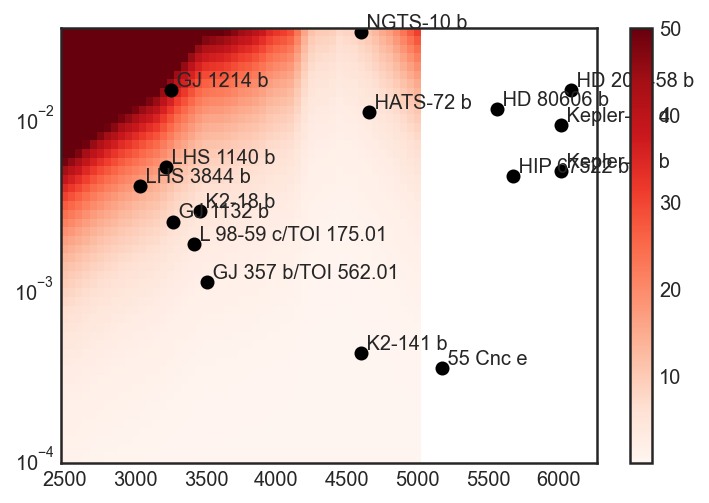

In [86]:
plt.pcolormesh(np.linspace(2500, 5000, 51), np.logspace(-4, -1, 50), Hs, vmin=0.001, vmax=50, cmap='Reds', shading='auto')
plt.colorbar()
plt.yscale('log')

for planet_name in jwstplanets:
    print(planet_name)
    try:
        t = NasaExoplanetArchive.query_object(planet_name.split('/')[0], regularize=False, table='pscomppars')
    except IndexError:
        try:
            t = NasaExoplanetArchive.query_object(planet_name.split('/')[1], regularize=False, table='pscomppars')
        except:
            continue
    if len(t) == 0:
        continue
    x, y = t['st_teff'].value[0], (t['pl_rade'][0].to(u.solRad)**2)/(t['st_rad'][0].to(u.solRad)**2)
    plt.scatter(x, y, c='k')
    plt.text(x, y, f' {planet_name}', ha='left', va='bottom')

100%|███████████████████████████████████████████| 51/51 [00:01<00:00, 38.94it/s]
/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_13706/3384022974.py:36: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contourf(spot_areas, -dspot_temps, H.T * 1e6, levels=[20, 1e10], color='k')


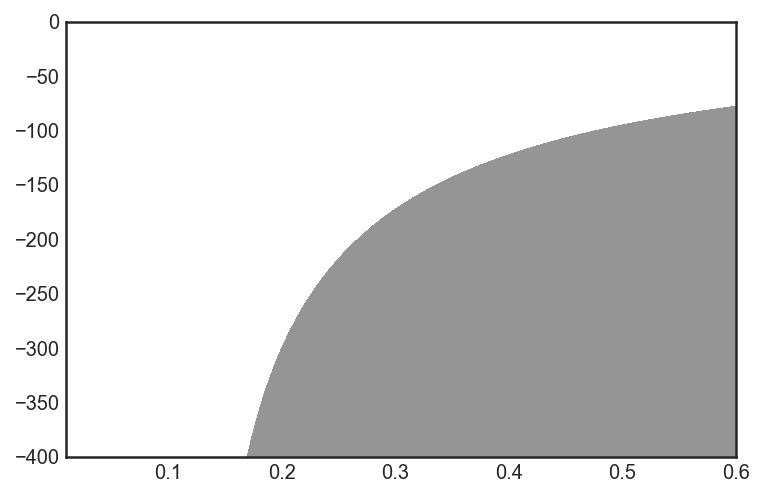

In [90]:
wavelength = np.linspace(1.12, 1.6, 300)
chi1 = np.sum(((sp.spec)**2/sp.spec_err**2))/len(wavelength - 1)
X2 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), wavelength * 1e4, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
dspot_temps = np.linspace(0, 400, 50)
spot_areas = np.linspace(0.01, 0.6, 51)

ts_models = np.zeros((51, 50, wavelength.shape[0]))
ts_models = np.zeros((51, 50))

apart = (wavelength >= 1.335) & (wavelength < 1.55)
bpart = (wavelength >= 1.15) & (wavelength < 1.335)

plt.figure()
planet_area = 0.001
star_temp = 3000
for idx, spot_area in enumerate(tqdm(spot_areas)):
    # temp of the photosphere
    phot_temps = dspot_temps * spot_area + star_temp
    spot_temps = phot_temps - dspot_temps
    spot_model = np.vstack([np.hstack([X2, X2 * spot_temp, X2 * spot_temp**2, X2 * spot_temp**3]).dot(w) for spot_temp in spot_temps]).T

#    phot_temps = (sp.meta['st_teff'] - (spot_area * spot_temps))/(1 - spot_area)
    phot_model = np.vstack([np.hstack([X2, X2 * phot_temp, X2 * phot_temp**2, X2 * phot_temp**3]).dot(w) for phot_temp in phot_temps]).T
    ###spot_model *= spot_temps**4/phot_temp**4

    #oot = (phot_model[:, None] * (1 - spot_area) + spot_model * spot_area)
    #it = (phot_model[:, None] * (1 - spot_area - planet_area) + spot_model * spot_area)
    oot = (phot_model * (1 - spot_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
    it = (phot_model * (1 - spot_area - planet_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
    ts_model = ((oot - it)/oot - planet_area)
    #This is a hack I shouldn't do
    ts_model -= np.nanmedian(ts_model, axis=0)
    ts_models[idx] = ts_model.T   
    maximum_variability[idx] = (phot_temps**4 * (1 - spot_area) + spot_temps**4 * spot_area)/(phot_temps**4)
    
    H = np.nanmax(ts_models[:, :, apart], axis=2) - np.nanmin(ts_models[:, :, bpart], axis=2)

plt.contourf(spot_areas, -dspot_temps, H.T * 1e6, levels=[20, 1e10], color='k')

array([8.10000000e+13, 8.10008640e+13, 8.10034571e+13, 8.10077812e+13,
       8.10138384e+13, 8.10216304e+13, 8.10311591e+13, 8.10424266e+13,
       8.10554346e+13, 8.10701852e+13, 8.10866803e+13, 8.11049219e+13,
       8.11249118e+13, 8.11466521e+13, 8.11701447e+13, 8.11953917e+13,
       8.12223949e+13, 8.12511564e+13, 8.12816781e+13, 8.13139622e+13,
       8.13480105e+13, 8.13838252e+13, 8.14214082e+13, 8.14607615e+13,
       8.15018873e+13, 8.15447876e+13, 8.15894644e+13, 8.16359197e+13,
       8.16841557e+13, 8.17341745e+13, 8.17859780e+13, 8.18395685e+13,
       8.18949479e+13, 8.19521185e+13, 8.20110823e+13, 8.20718414e+13,
       8.21343980e+13, 8.21987542e+13, 8.22649121e+13, 8.23328740e+13,
       8.24026419e+13, 8.24742180e+13, 8.25476045e+13, 8.26228035e+13,
       8.26998173e+13, 8.27786480e+13, 8.28592979e+13, 8.29417691e+13,
       8.30260638e+13, 8.31121843e+13])

In [95]:
(spot_temps**4/phot_temps**4) * spot_area

array([0.6       , 0.59350655, 0.58708683, 0.58073994, 0.57446499,
       0.5682611 , 0.56212741, 0.55606308, 0.55006725, 0.54413911,
       0.53827782, 0.53248259, 0.52675262, 0.52108711, 0.51548529,
       0.50994641, 0.50446969, 0.49905439, 0.49369978, 0.48840513,
       0.48316972, 0.47799284, 0.4728738 , 0.4678119 , 0.46280646,
       0.45785681, 0.45296229, 0.44812223, 0.443336  , 0.43860296,
       0.43392247, 0.42929392, 0.42471668, 0.42019015, 0.41571374,
       0.41128686, 0.40690891, 0.40257932, 0.39829753, 0.39406298,
       0.3898751 , 0.38573336, 0.38163721, 0.37758611, 0.37357955,
       0.369617  , 0.36569795, 0.36182189, 0.35798832, 0.35419675])

100%|███████████████████████████████████████████| 51/51 [00:01<00:00, 35.26it/s]
/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_6821/1530203780.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(spot_areas, -dspot_temps, rchi.T, cmap='viridis_r', vmin=rchi.min(), vmax=rchi.min()+0.001)
/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_6821/1530203780.py:66: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax1.pcolormes

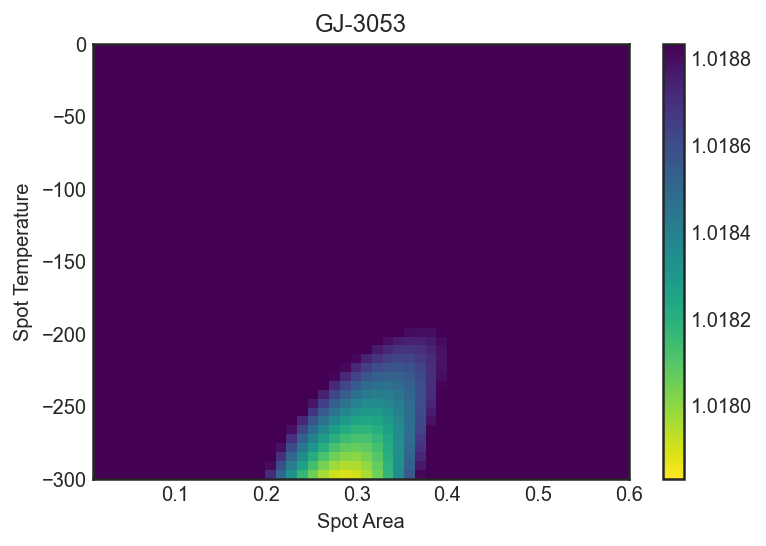

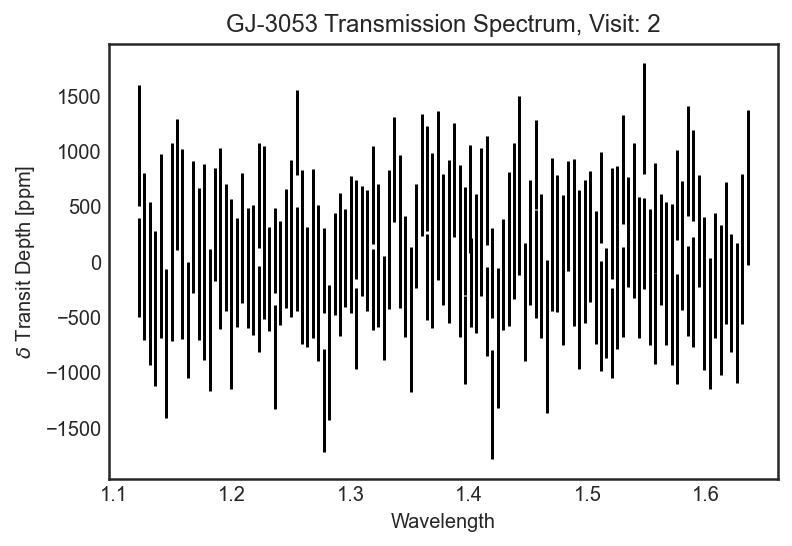

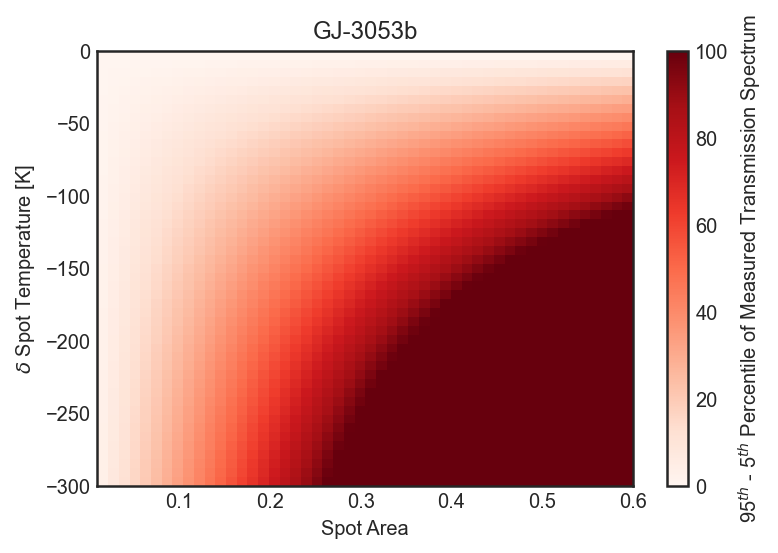

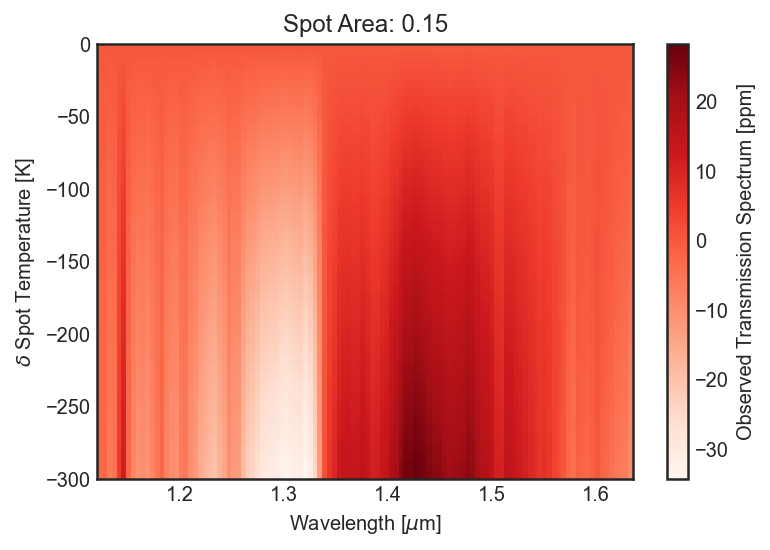

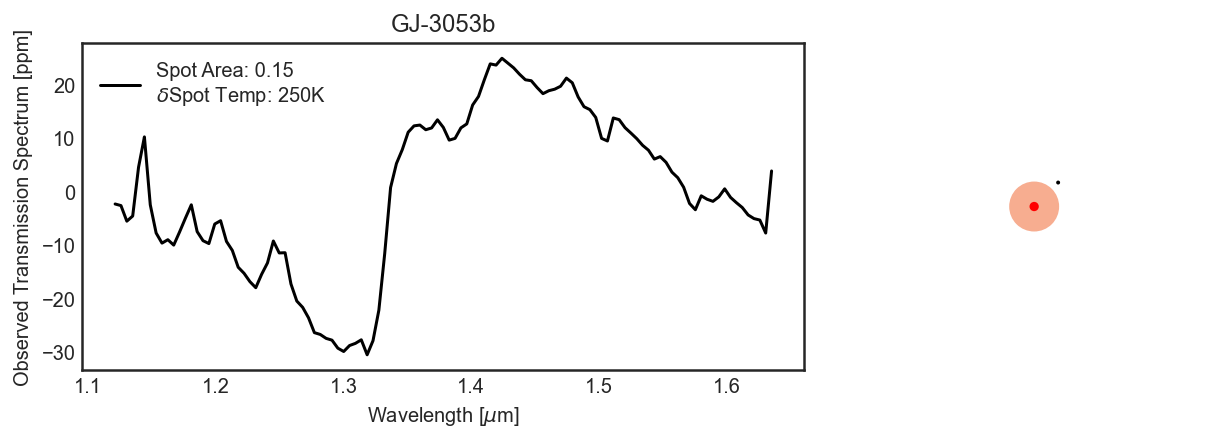

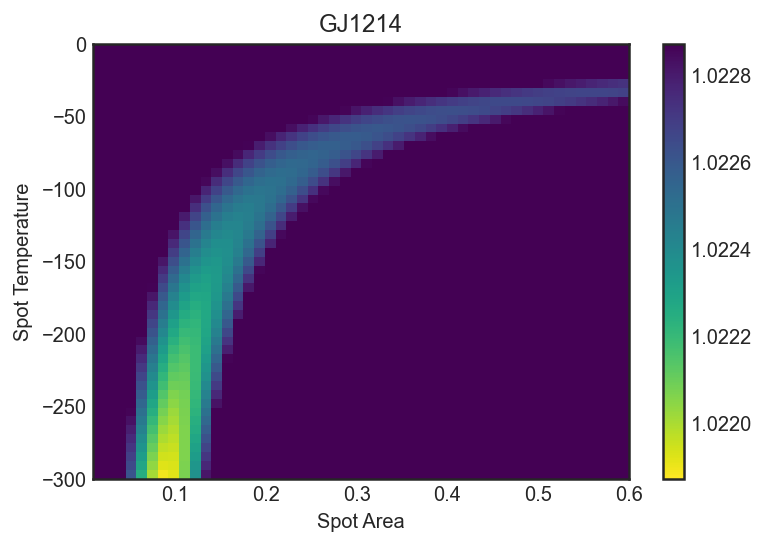

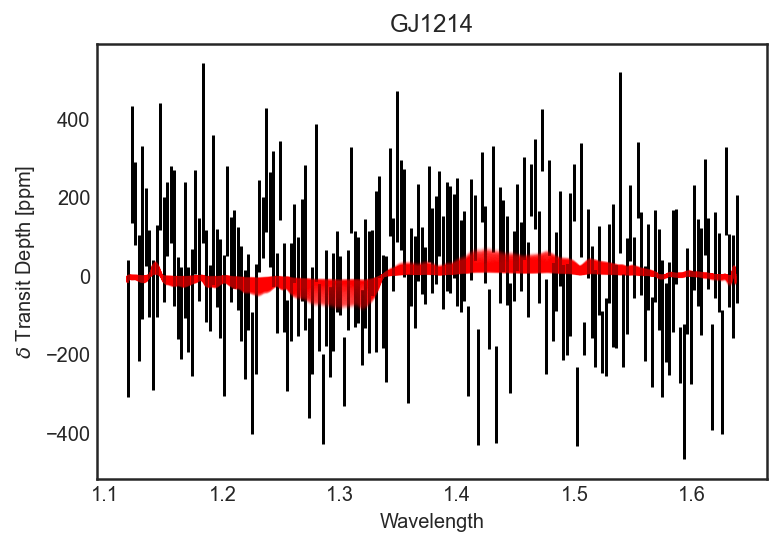

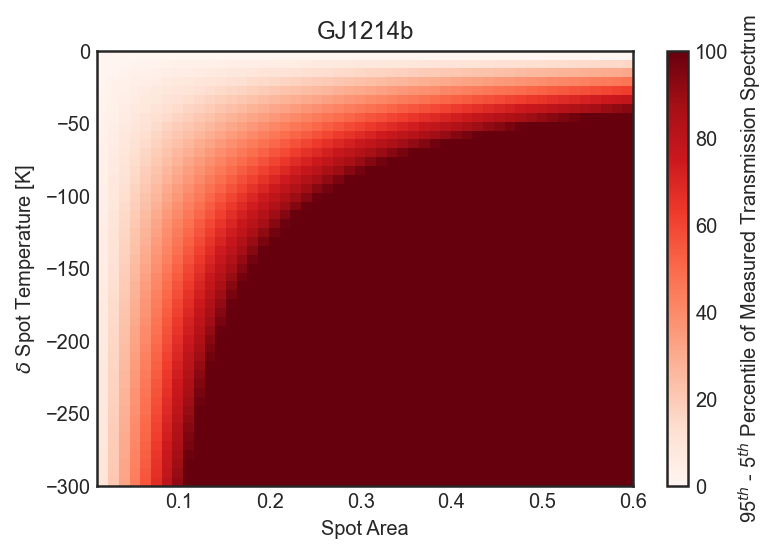

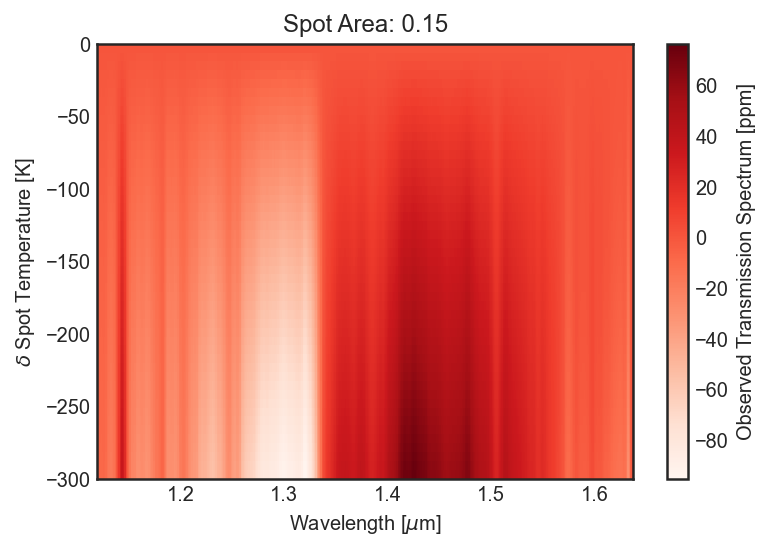

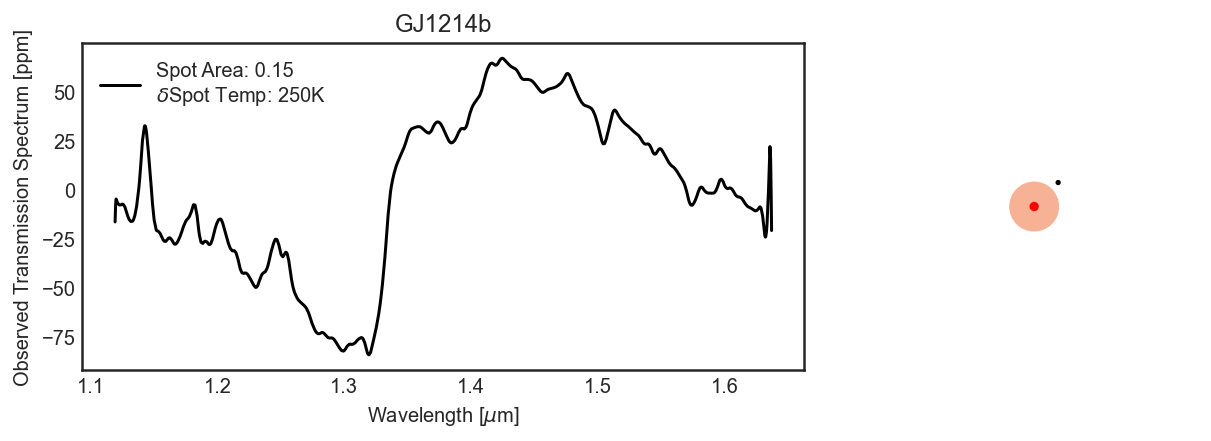

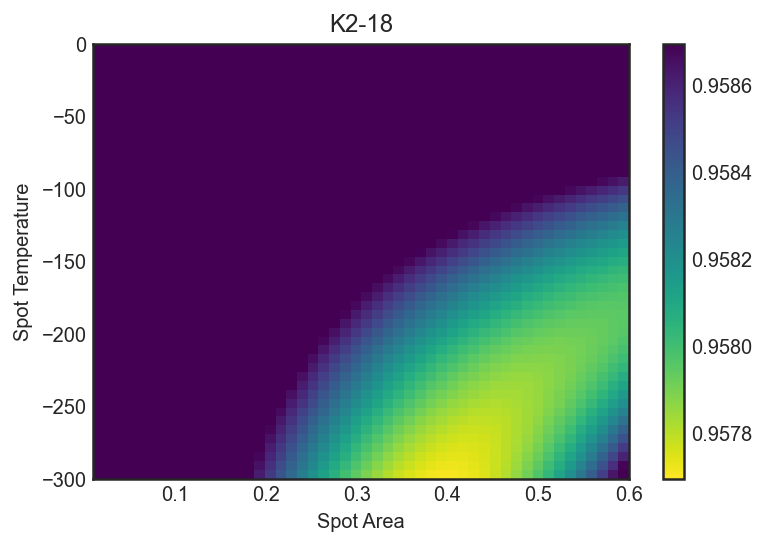

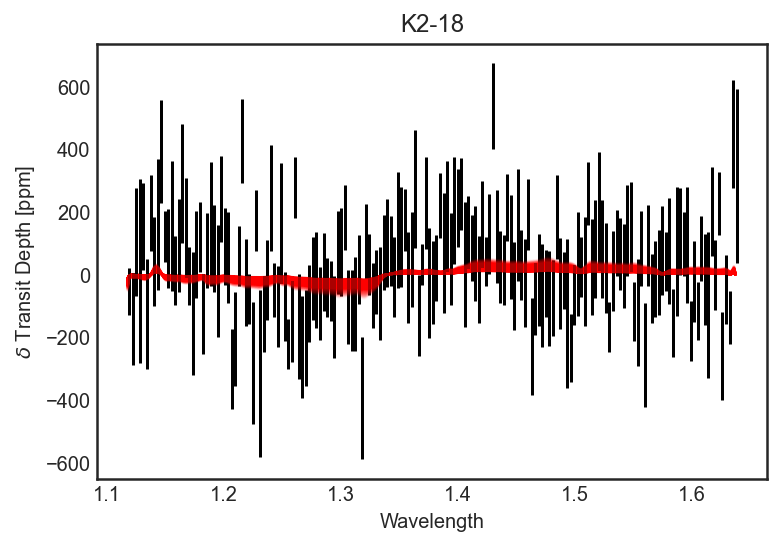

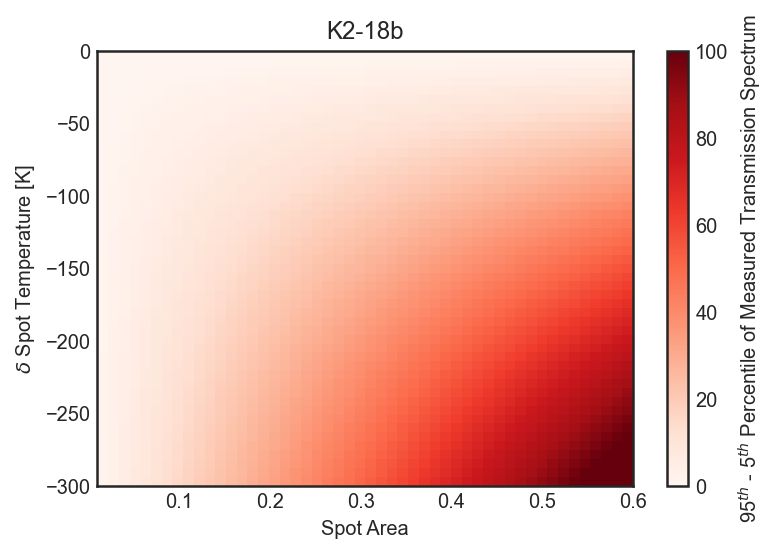

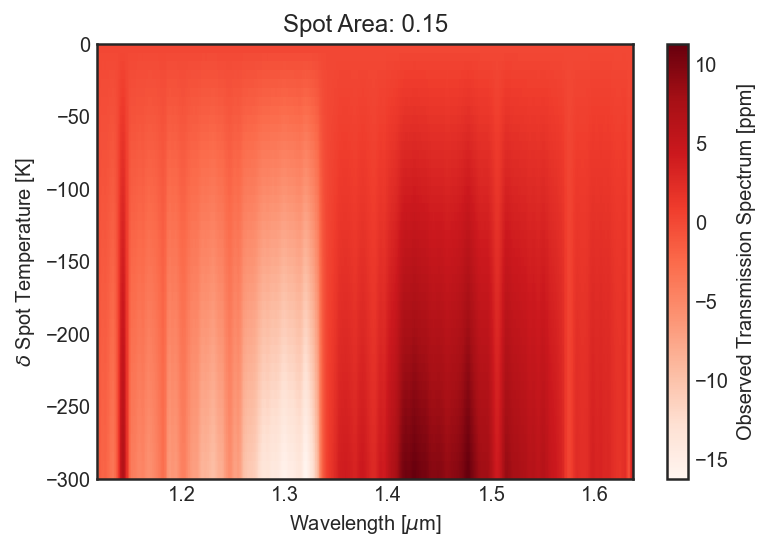

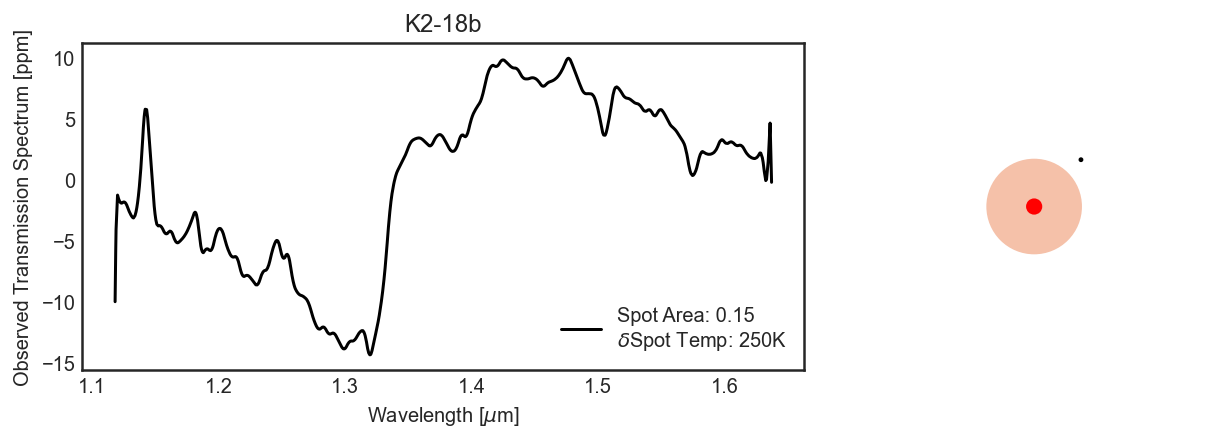

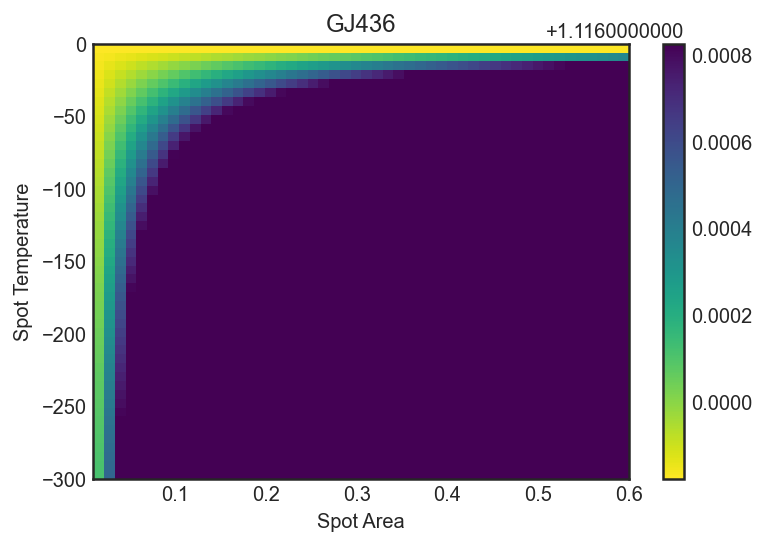

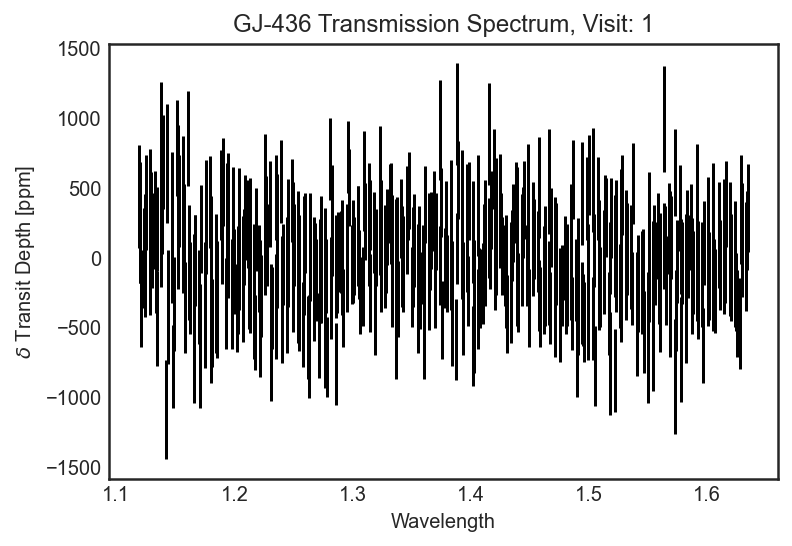

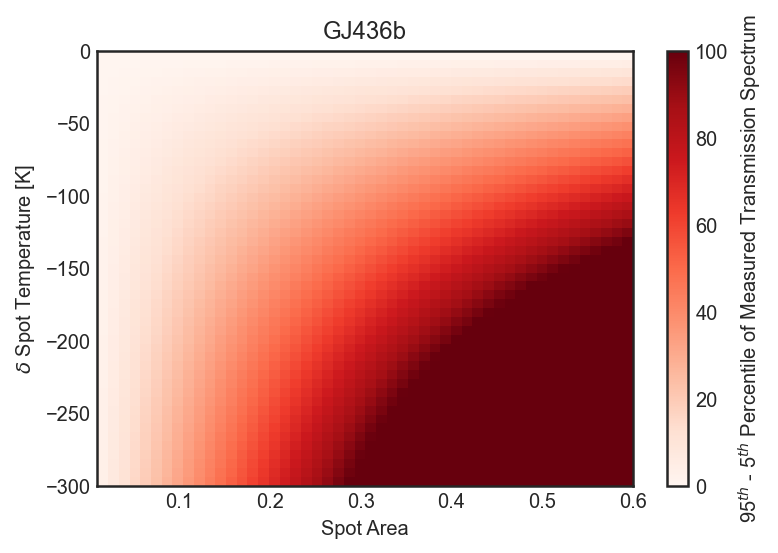

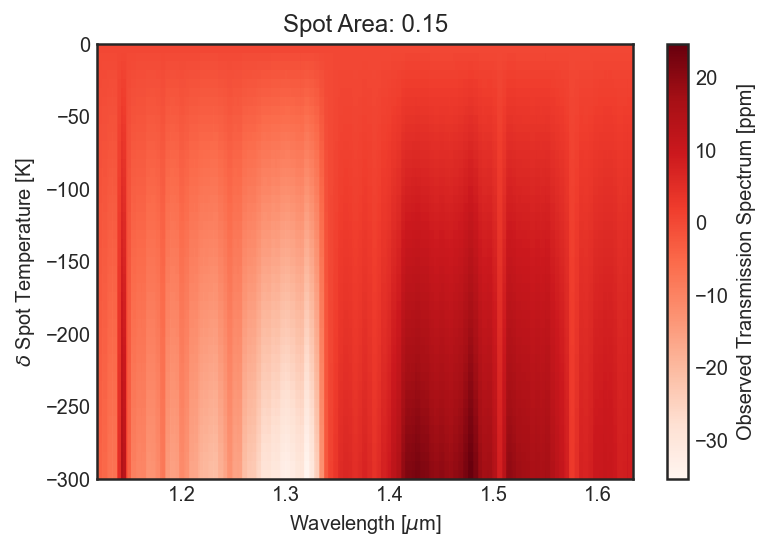

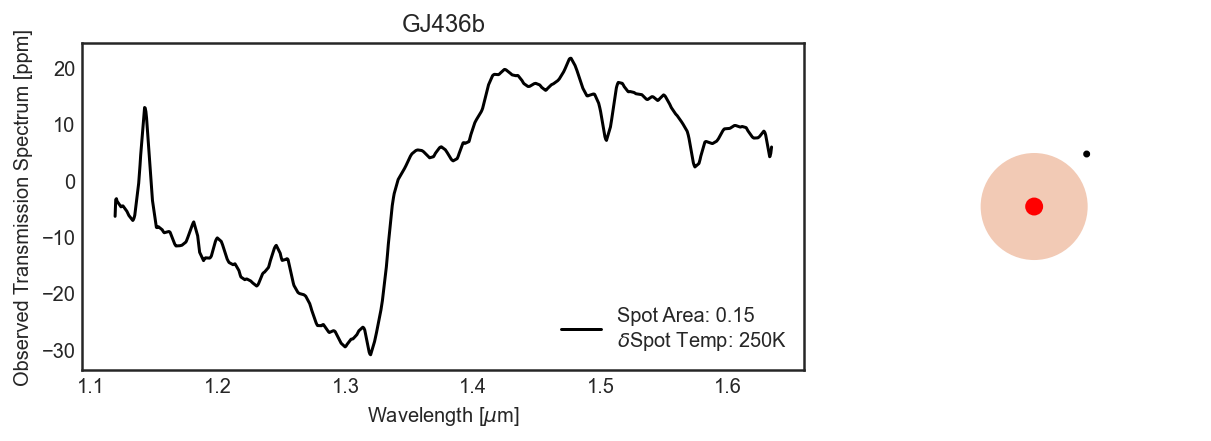

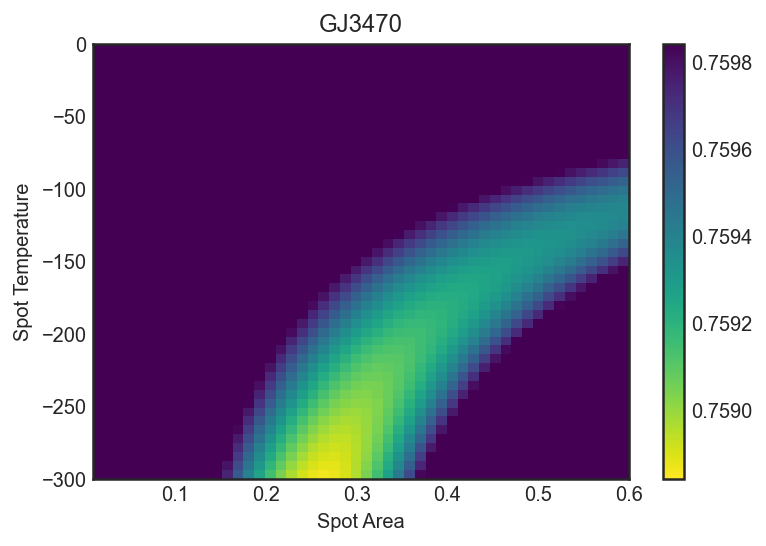

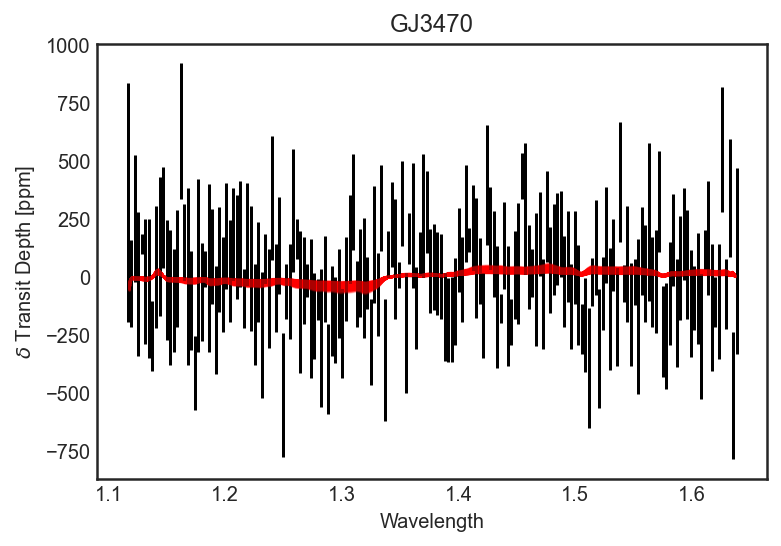

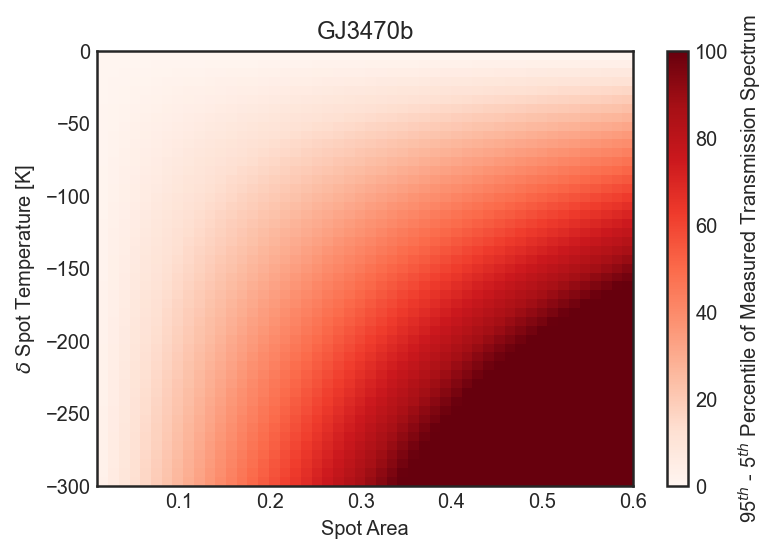

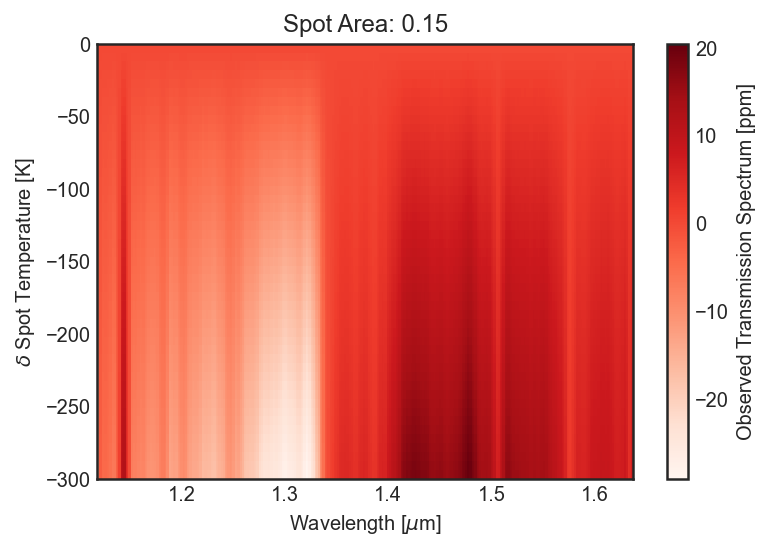

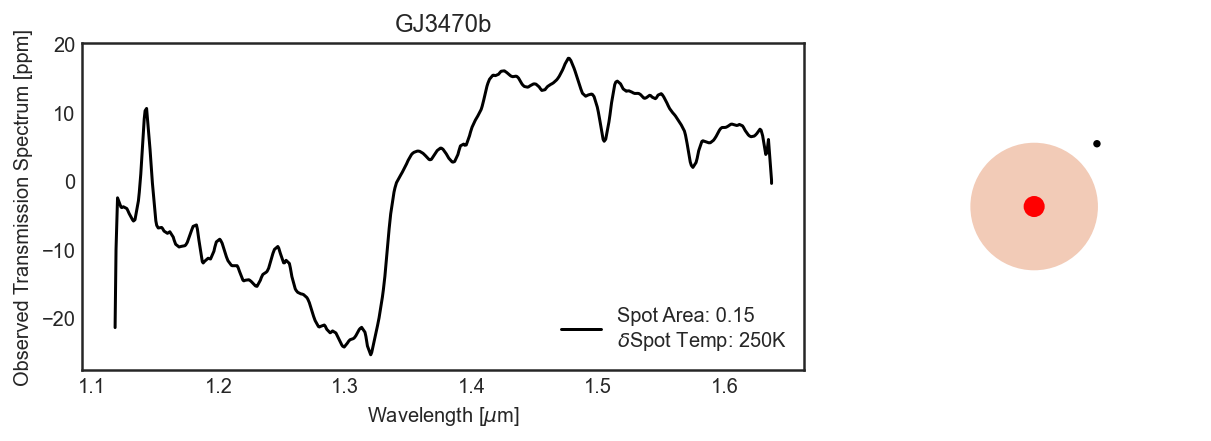

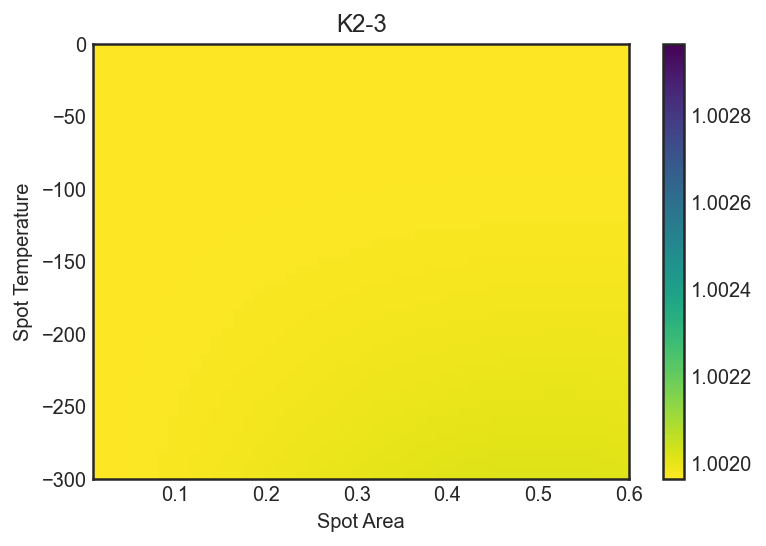

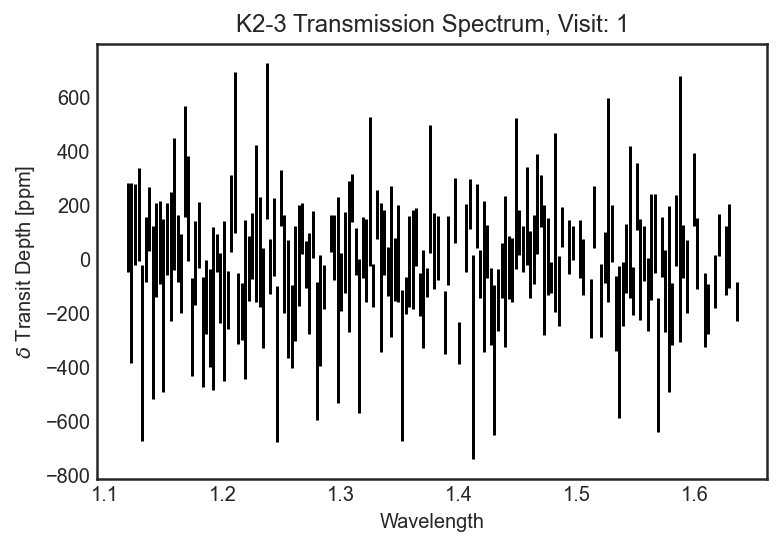

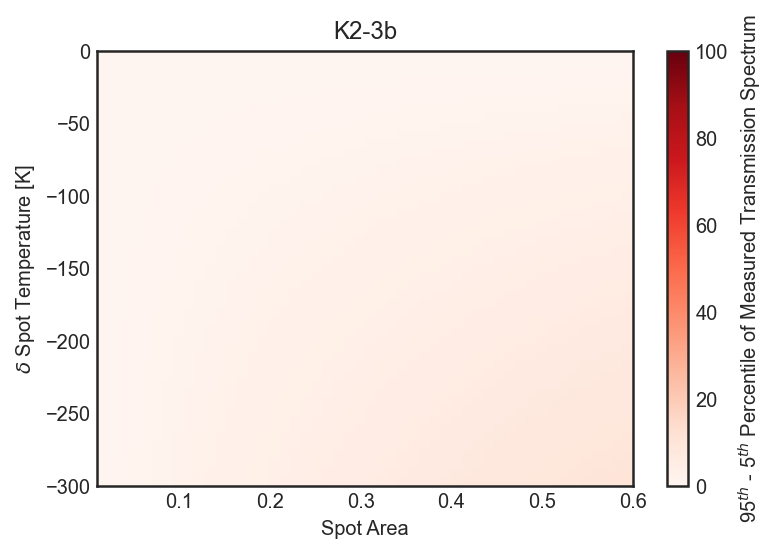

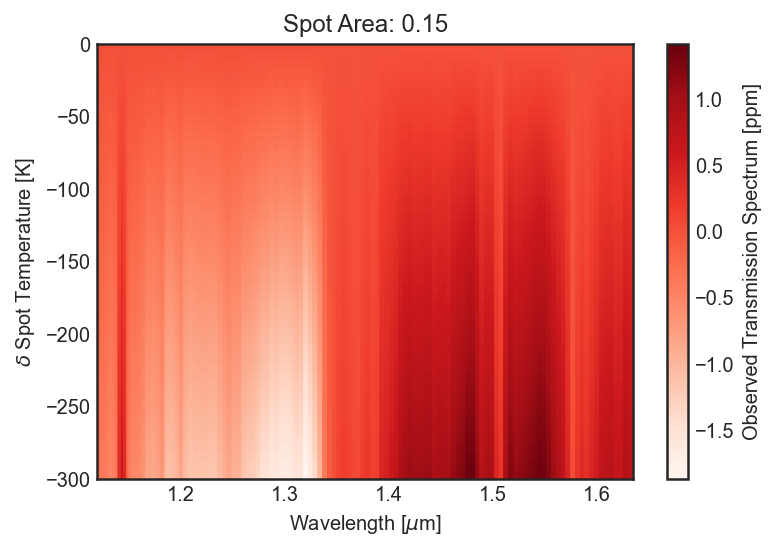

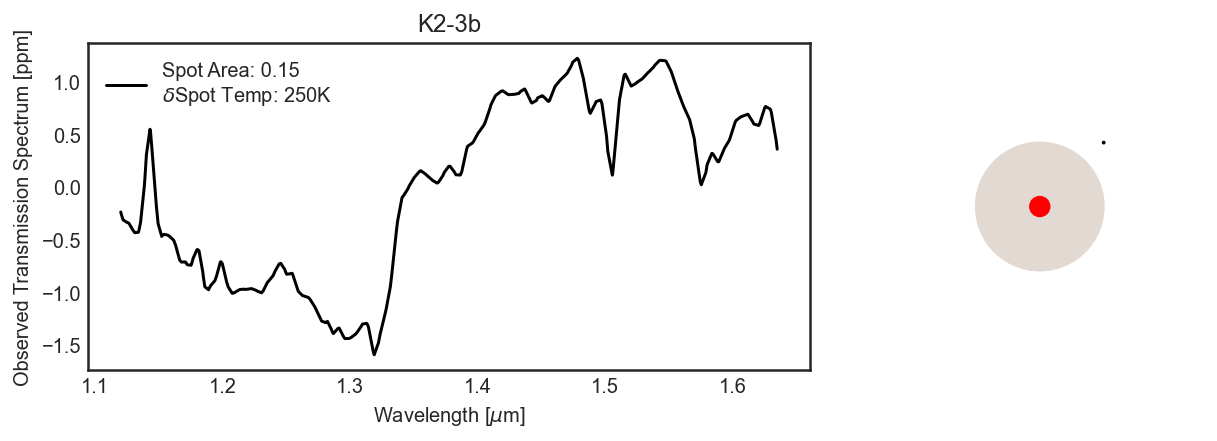

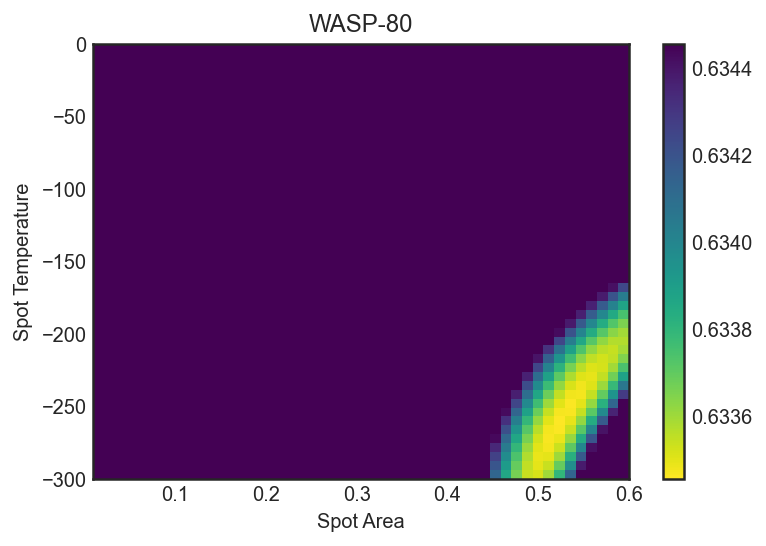

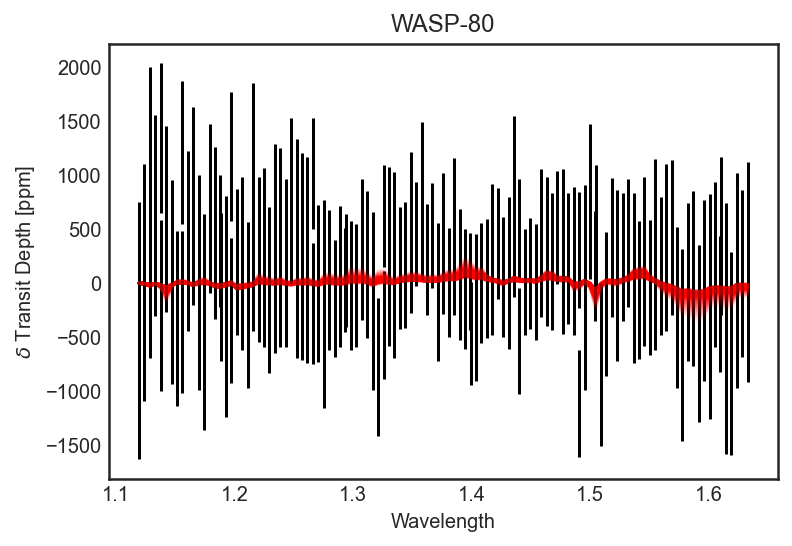

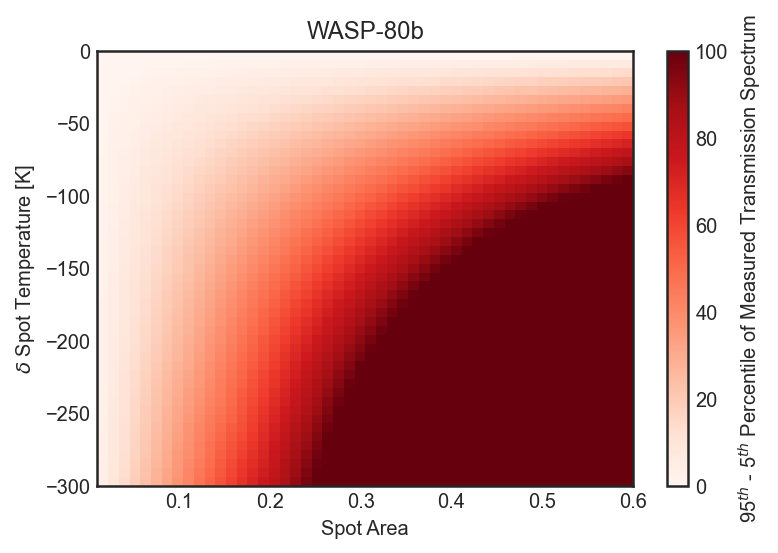

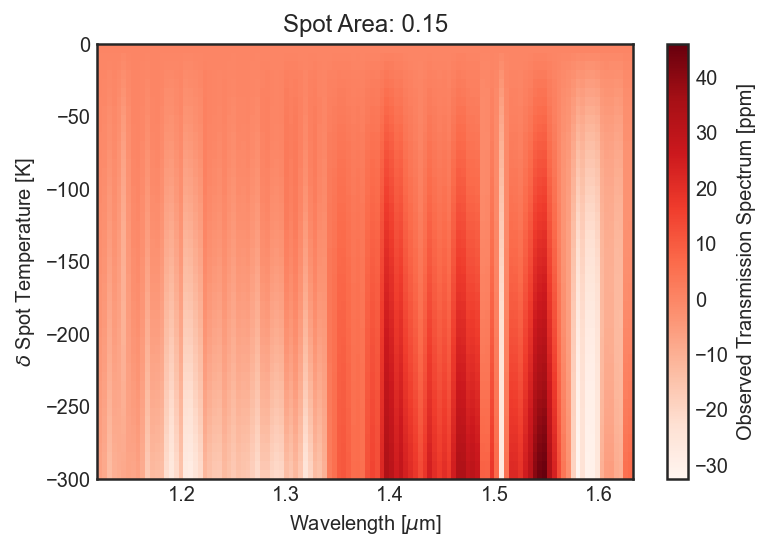

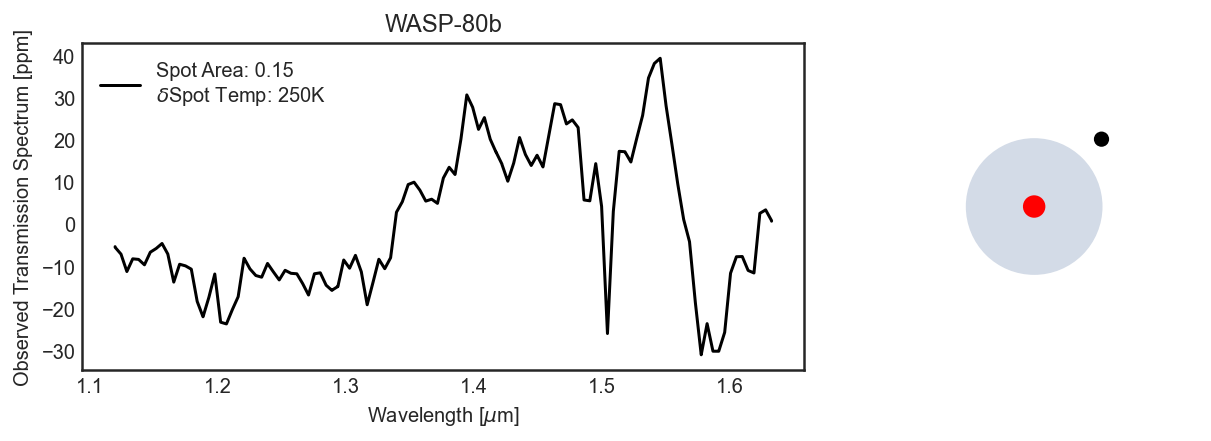

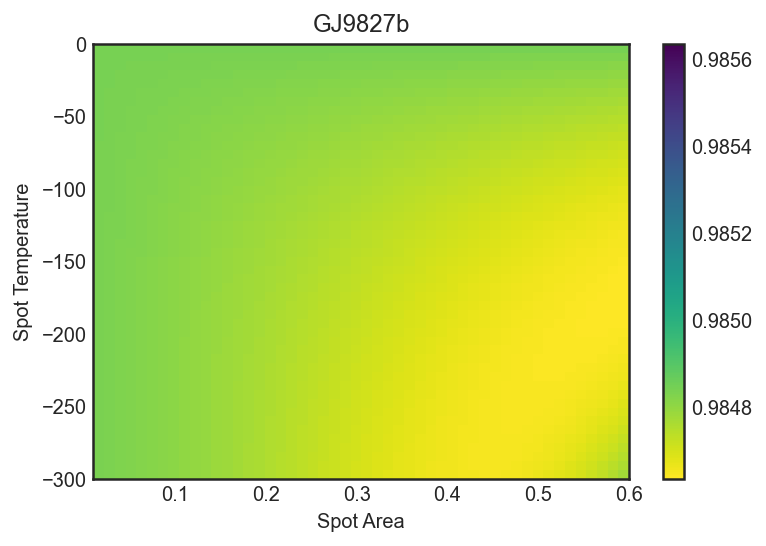

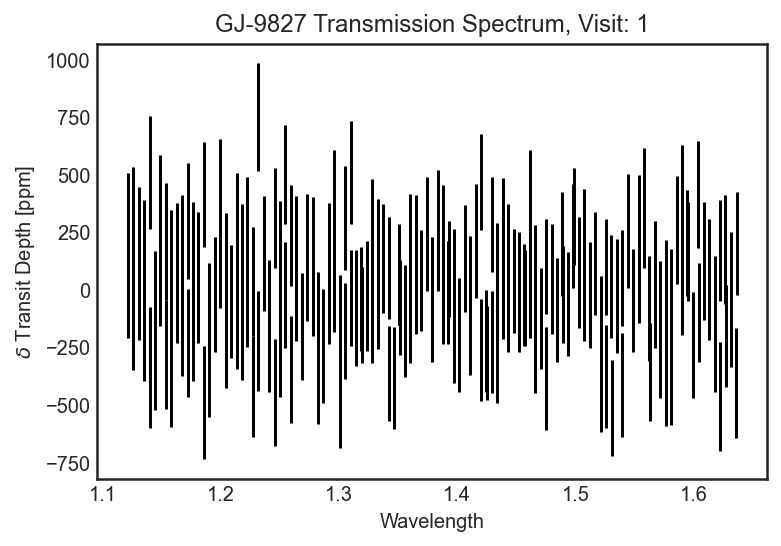

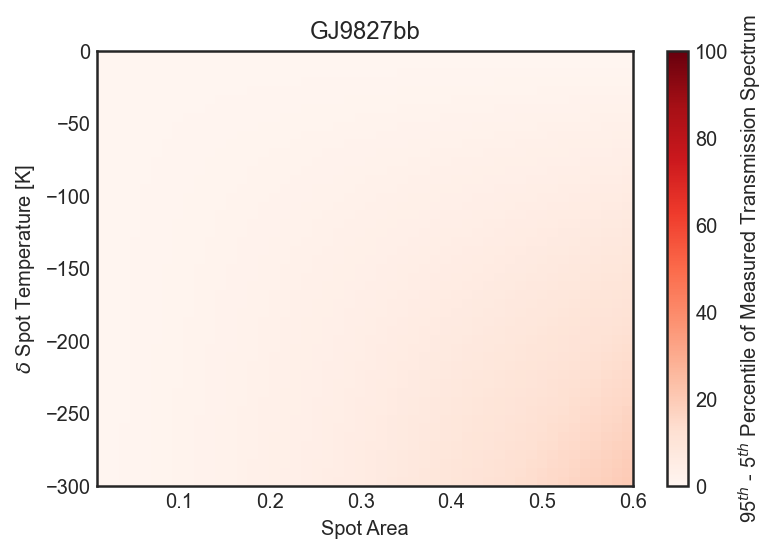

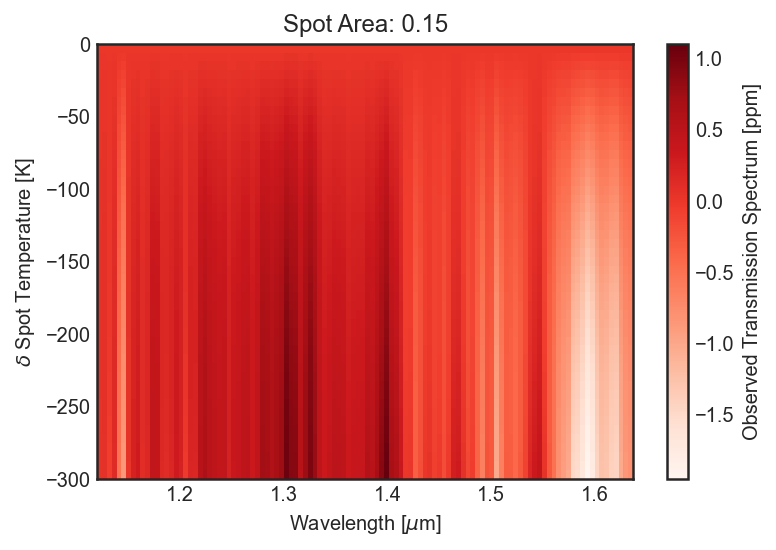

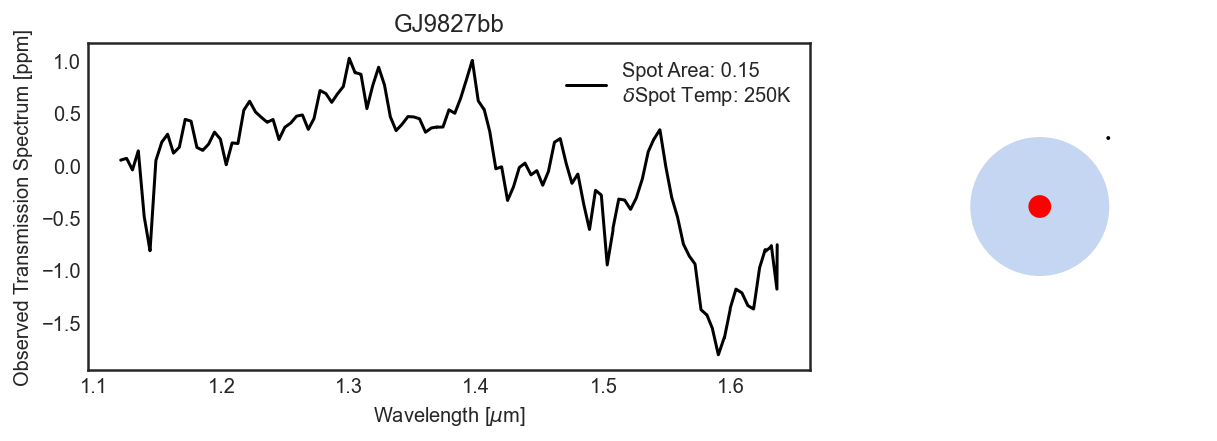

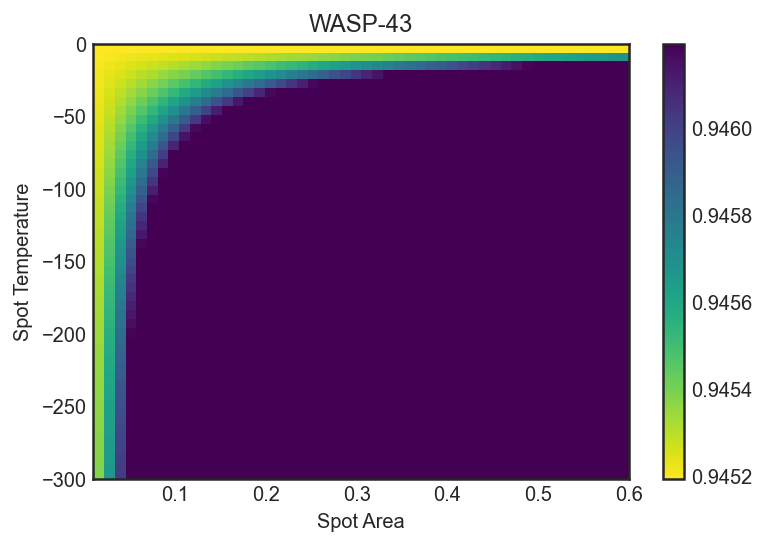

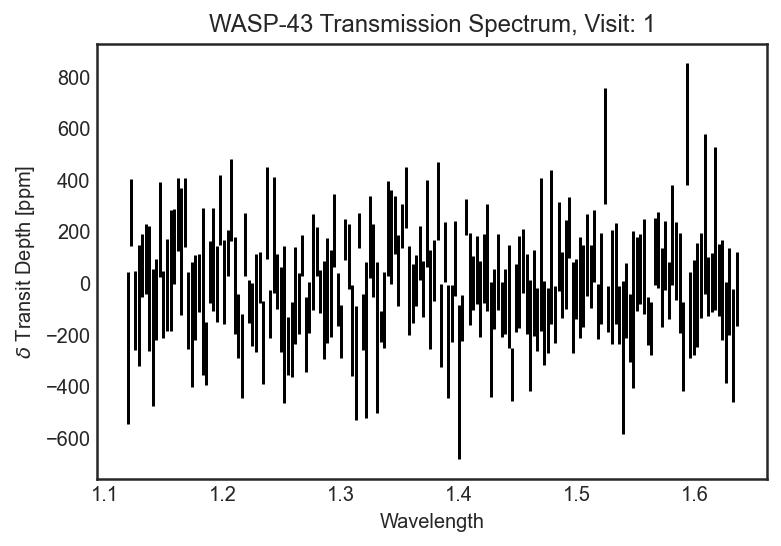

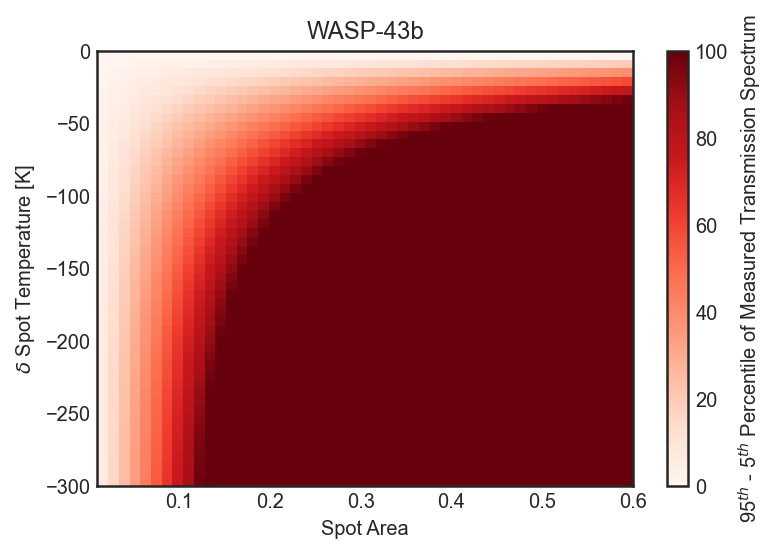

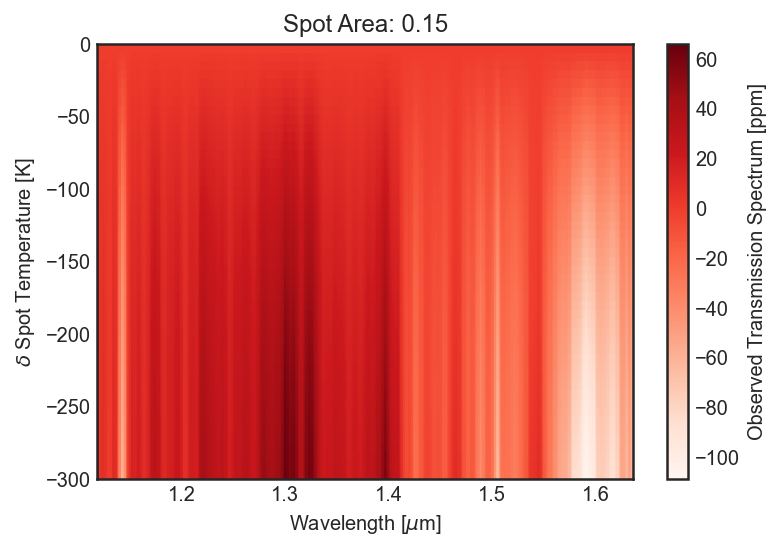

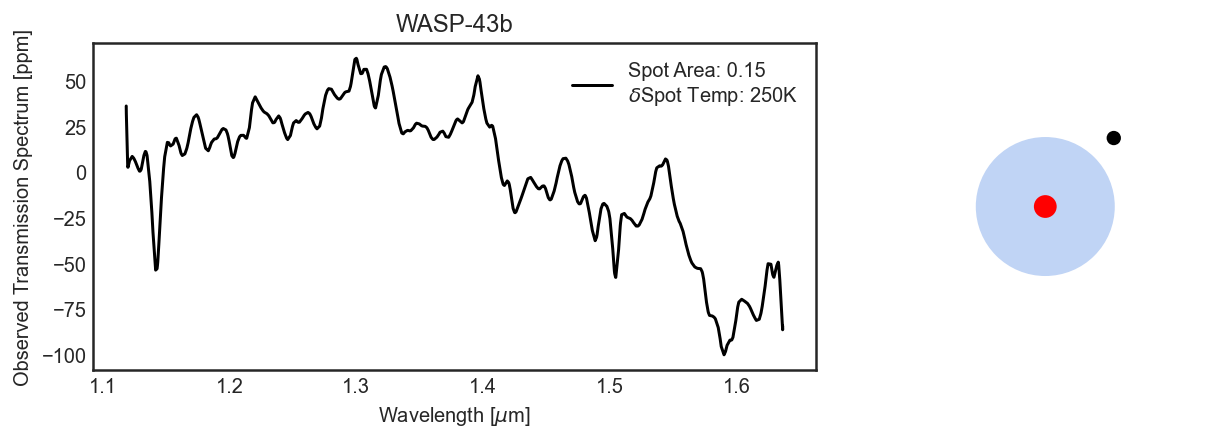

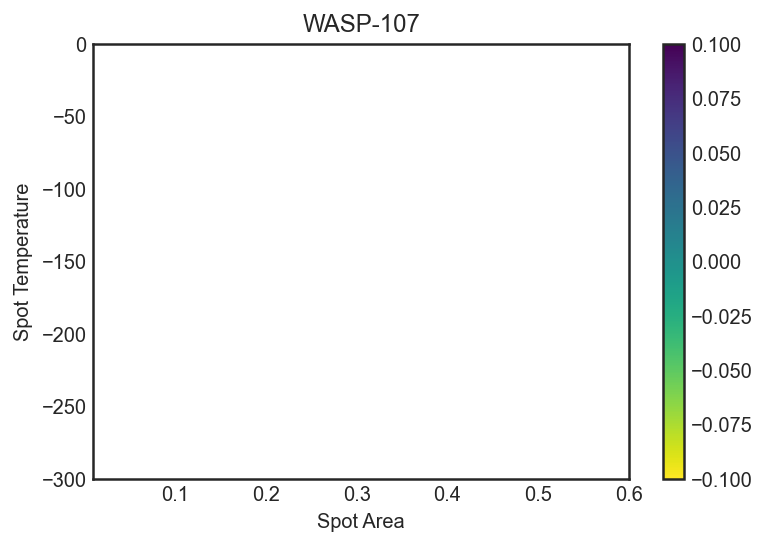

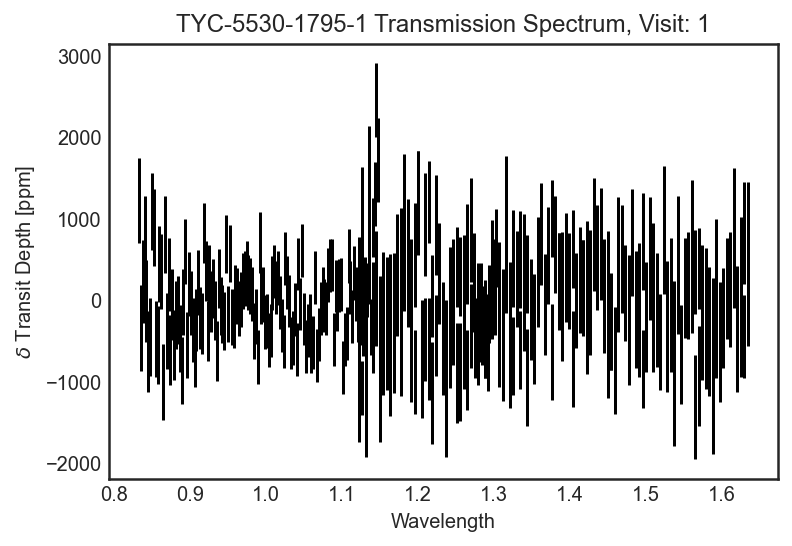

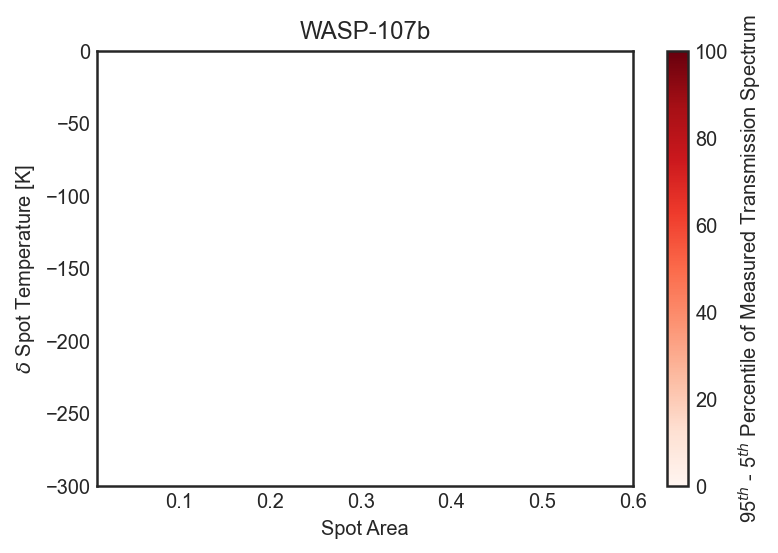

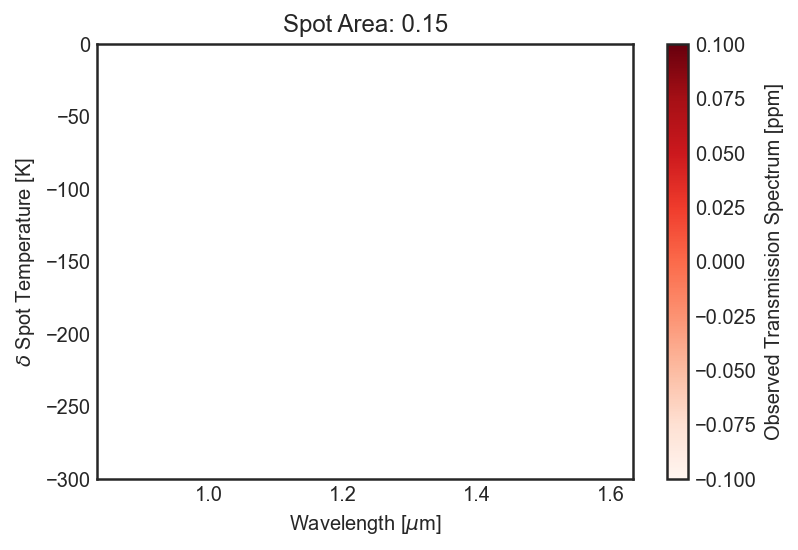

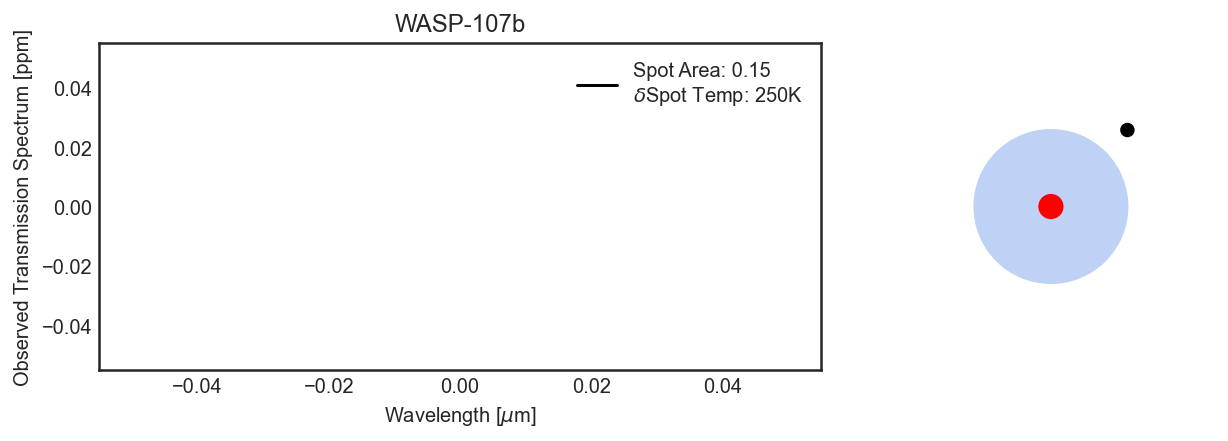

In [218]:
for name in pnames:
    if not os.path.isfile(f'results/{name}_transmission.fits'):
        continue
    sp = Spectra.from_file(f'results/{name}_transmission.fits').flatten()
    sp = sp[np.argsort(sp.wavelength.value)]
    chi1 = np.sum(((sp.spec)**2/sp.spec_err**2))/len(sp.wavelength.value - 1)
    X2 = lk.designmatrix.create_spline_matrix(np.hstack([wknots.min(), sp.wavelength.value * 1e4, wknots.max()]), knots=list(wknots), degree=2).X[1:-1]
    phot_temp = sp.meta['st_teff']

    #spot_temps = np.linspace(phot_temp - 500, phot_temp)[::-1]

    # Spot temperature compared to photosphere
    dspot_temps = np.linspace(0, 300, 50)

    #phot_model = np.hstack([X2, X2 * phot_temp, X2 * phot_temp**2]).dot(w)
    #spot_model = np.hstack([X1, X1 * spot_temp, X1 * spot_temp**2]).dot(w)


    #spot_model = np.vstack([np.hstack([X2, X2 * spot_temp, X2 * spot_temp**2]).dot(w) for spot_temp in spot_temps]).T
    #spot_model *= spot_temps**4/phot_temp**4
    spot_areas = np.linspace(0.01, 0.6, 51)
    rchi = np.zeros((51, 50))
    ts_models = np.zeros((51, 50, sp.wavelength.value.shape[0]))
    planet_area = sp.meta['radius']**2/sp.meta['st_rad']**2
    phot_temps_all = np.zeros((51, 50))
    for idx, spot_area in enumerate(tqdm(spot_areas)):
        # temp of the photosphere
        phot_temps = dspot_temps * spot_area + sp.meta['st_teff']
        spot_temps = phot_temps - dspot_temps
        spot_model = np.vstack([np.hstack([X2, X2 * spot_temp, X2 * spot_temp**2, X2 * spot_temp**3]).dot(w) for spot_temp in spot_temps]).T

    #    phot_temps = (sp.meta['st_teff'] - (spot_area * spot_temps))/(1 - spot_area)
        phot_model = np.vstack([np.hstack([X2, X2 * phot_temp, X2 * phot_temp**2, X2 * phot_temp**3]).dot(w) for phot_temp in phot_temps]).T
        ###spot_model *= spot_temps**4/phot_temp**4

        #oot = (phot_model[:, None] * (1 - spot_area) + spot_model * spot_area)
        #it = (phot_model[:, None] * (1 - spot_area - planet_area) + spot_model * spot_area)
        oot = (phot_model * (1 - spot_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
        it = (phot_model * (1 - spot_area - planet_area) + spot_model * spot_area * spot_temps**4/phot_temps**4)
        ts_model = ((oot - it)/oot - planet_area)
        #This is a hack I shouldn't do
        ts_model -= np.mean(ts_model, axis=0)
        rchi[idx] = np.sum((sp.spec.value[:, None] - ts_model*1e6)**2/sp.spec_err.value[:, None]**2, axis=0)/(sp.spec.shape[0] - 3)
        ts_models[idx] = ts_model.T    
        phot_temps_all[idx] = phot_temps

    plt.figure()
    plt.pcolormesh(spot_areas, -dspot_temps, rchi.T, cmap='viridis_r', vmin=rchi.min(), vmax=rchi.min()+0.001)
    plt.colorbar()
    plt.xlabel('Spot Area')
    plt.ylabel("Spot Temperature")
    plt.title(name)

    if len(sp.wavelength.value) > 600:
        ax = sp.bin(np.linspace(1.1, 1.7, 200)).plot(ls='', c='k', label='HST WFC3 data', zorder=-1)
    else:
        ax = sp.plot(ls='', c='k', label='HST WFC3 data', zorder=-1)
    l = np.asarray(np.where(rchi < chi1)).T
    if len(l) != 0:
        ax.plot(sp.wavelength.value[np.argsort(sp.wavelength.value)], 1e6 * ts_models[l[:, 0], l[:, 1]].T[np.argsort(sp.wavelength.value)], c='r', alpha=0.01);

        #ax.scatter(sp.wavelength.value, 1e6*ts_model[:, l[1]], color='C3', zorder=1, label=f'Spot Model. Area:{np.round(spot_area, 2)}, SpotTemp:{int(spot_temp)}K')
        ax.set(title=name)

    fig, ax1 = plt.subplots()
    im = ax1.pcolormesh(spot_areas, -dspot_temps, (np.diff(np.percentile(ts_models, [5, 95], axis=2), axis=0)[0] * 1e6).T, vmin=0, vmax=100, cmap='Reds')
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('95$^{th}$ - 5$^{th}$ Percentile of Measured Transmission Spectrum')
    ax1.set(title=(f"{name}b"), xlabel='Spot Area', ylabel='$\delta$ Spot Temperature [K]')


    norm = mpl.colors.Normalize(vmin=2000, vmax=6000)
    cmap = plt.get_cmap('coolwarm_r')


    adx = 12
    fig, ax1 = plt.subplots()
    im = ax1.pcolormesh(sp.wavelength.value, -dspot_temps, ts_models[adx] * 1e6, cmap='Reds');
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label("Observed Transmission Spectrum [ppm]")
    ax1.set(title=(f"Spot Area: {np.round(spot_areas[adx], 2)}"), xlabel='Wavelength [$\mu$m]', ylabel='$\delta$ Spot Temperature [K]')


    fig = plt.figure(figsize=(10, 3))
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((1, 3), (0, 2))
    ax.plot(sp.wavelength.value, ts_models[adx, -9, :] *1e6, c='k', label=f'Spot Area: {np.round(spot_areas[adx], 2)}\n$\delta$Spot Temp: {int(np.round(dspot_temps[-9], -1))}K')
    ax.set(title=(f"{name}b"), xlabel='Wavelength [$\mu$m]', ylabel='Observed Transmission Spectrum [ppm]')
    ax.legend()

    star = plt.Circle((0.5, 0.5), sp.meta['st_rad'] * 0.35, color=cmap(norm(sp.meta['st_teff'])))
    spot = plt.Circle((0.5, 0.5), sp.meta['st_rad'] * spot_areas[adx] * 0.35, color='red')
    planet = plt.Circle((0.5 + sp.meta['st_rad'] * 0.35, 0.5 + sp.meta['st_rad'] * 0.35), sp.meta['st_rad'] * (planet_area/np.pi)**0.5 * 0.35, color='black')

    ax2.set_aspect('equal')
    plt.axis('off')

    ax2.add_patch(star)
    ax2.add_patch(spot)
    ax2.add_patch(planet)